In [59]:
import pandas as pd
import numpy as np
import requests, re
from typing import List, Literal
import matplotlib.pyplot as plt

In [43]:
def get_soi_data(start=2010, end=2025):
    """
    Download standardized monthly SOI index from NOAA.
    start and end can be:
      - 4-digit year (e.g., 2010)
      - or 6-digit year+month (e.g., 201003 for March 2010)
    """
    def to_timestamp(val, default_month):
        """Convert 4- or 6-digit year/month to pd.Timestamp"""
        val = int(val)
        if val < 10000:
            return pd.Timestamp(year=val, month=default_month, day=15)
        else:
            return pd.Timestamp(year=val // 100, month=val % 100, day=15)

    # Normalize start and end to Timestamps
    start_ts = to_timestamp(start, default_month=1)
    end_ts   = to_timestamp(end,   default_month=12)

    try:
        url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
        response = requests.get(url, timeout=30)
        lines = response.text.strip().split('\n')

        # === Step 1: Locate standardized SOI section
        for i, line in enumerate(lines):
            if "STANDARDIZED" in line:
                start_idx = i + 2
                break
        else:
            raise ValueError("Standardized SOI section not found")

        # === Step 2: Parse monthly data
        data = []
        for line in lines[start_idx:]:
            line = re.sub(r'(?<=[0-9])-(?=[0-9])', ' -', line)
            parts = line.split()
            if not parts or not parts[0].isdigit():
                continue
            year = int(parts[0])
            if len(parts) < 13:
                continue
            for m in range(1, 13):
                try:
                    val = float(parts[m])
                    if val == -999.9:
                        continue
                    date = pd.Timestamp(year, m, 15)
                    if start_ts <= date <= end_ts:
                        data.append({"date": date, "SOI": val})
                except ValueError:
                    continue

        return pd.DataFrame(data).set_index("date")

    except Exception as e:
        print("Using synthetic SOI due to error:", e)
        dates = pd.date_range(start_ts, end_ts, freq="MS")
        t = np.arange(len(dates))
        soi = 2 * np.sin(2*np.pi*t/24) + np.random.normal(0, 0.5, len(dates))
        return pd.DataFrame({'SOI': soi}, index=dates)


In [47]:
soi = get_soi_data(1950,2025)
# print(soi)

In [ ]:
def plot_eemd_decomposition_series(series: pd.Series, label="SOI", max_imfs=None):
    from PyEMD import EEMD
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np

    # Interpolate any gaps
    series = series.interpolate("time").dropna()
    x = series.values
    t = np.arange(len(x))

    eemd = EEMD(trials=100, noise_width=0.2)
    eemd.eemd(x, t)
    IMFs, residual = eemd.get_imfs_and_residue()

    n_imfs = IMFs.shape[0] if max_imfs is None else min(IMFs.shape[0], max_imfs)
    fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(12, 2.2*(n_imfs+1)), sharex=True)

    for i in range(n_imfs):
        axes[i].plot(series.index, IMFs[i], label=f"IMF {i+1}")
        axes[i].legend(loc="upper right")
        axes[i].grid(alpha=0.3)

    axes[-1].plot(series.index, residual, 'k', label="Residual (trend)")
    axes[-1].legend(loc="upper right")
    axes[-1].grid(alpha=0.3)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    fig.suptitle(f"EEMD decomposition of {label} series", fontsize=14)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    return series, IMFs, residual


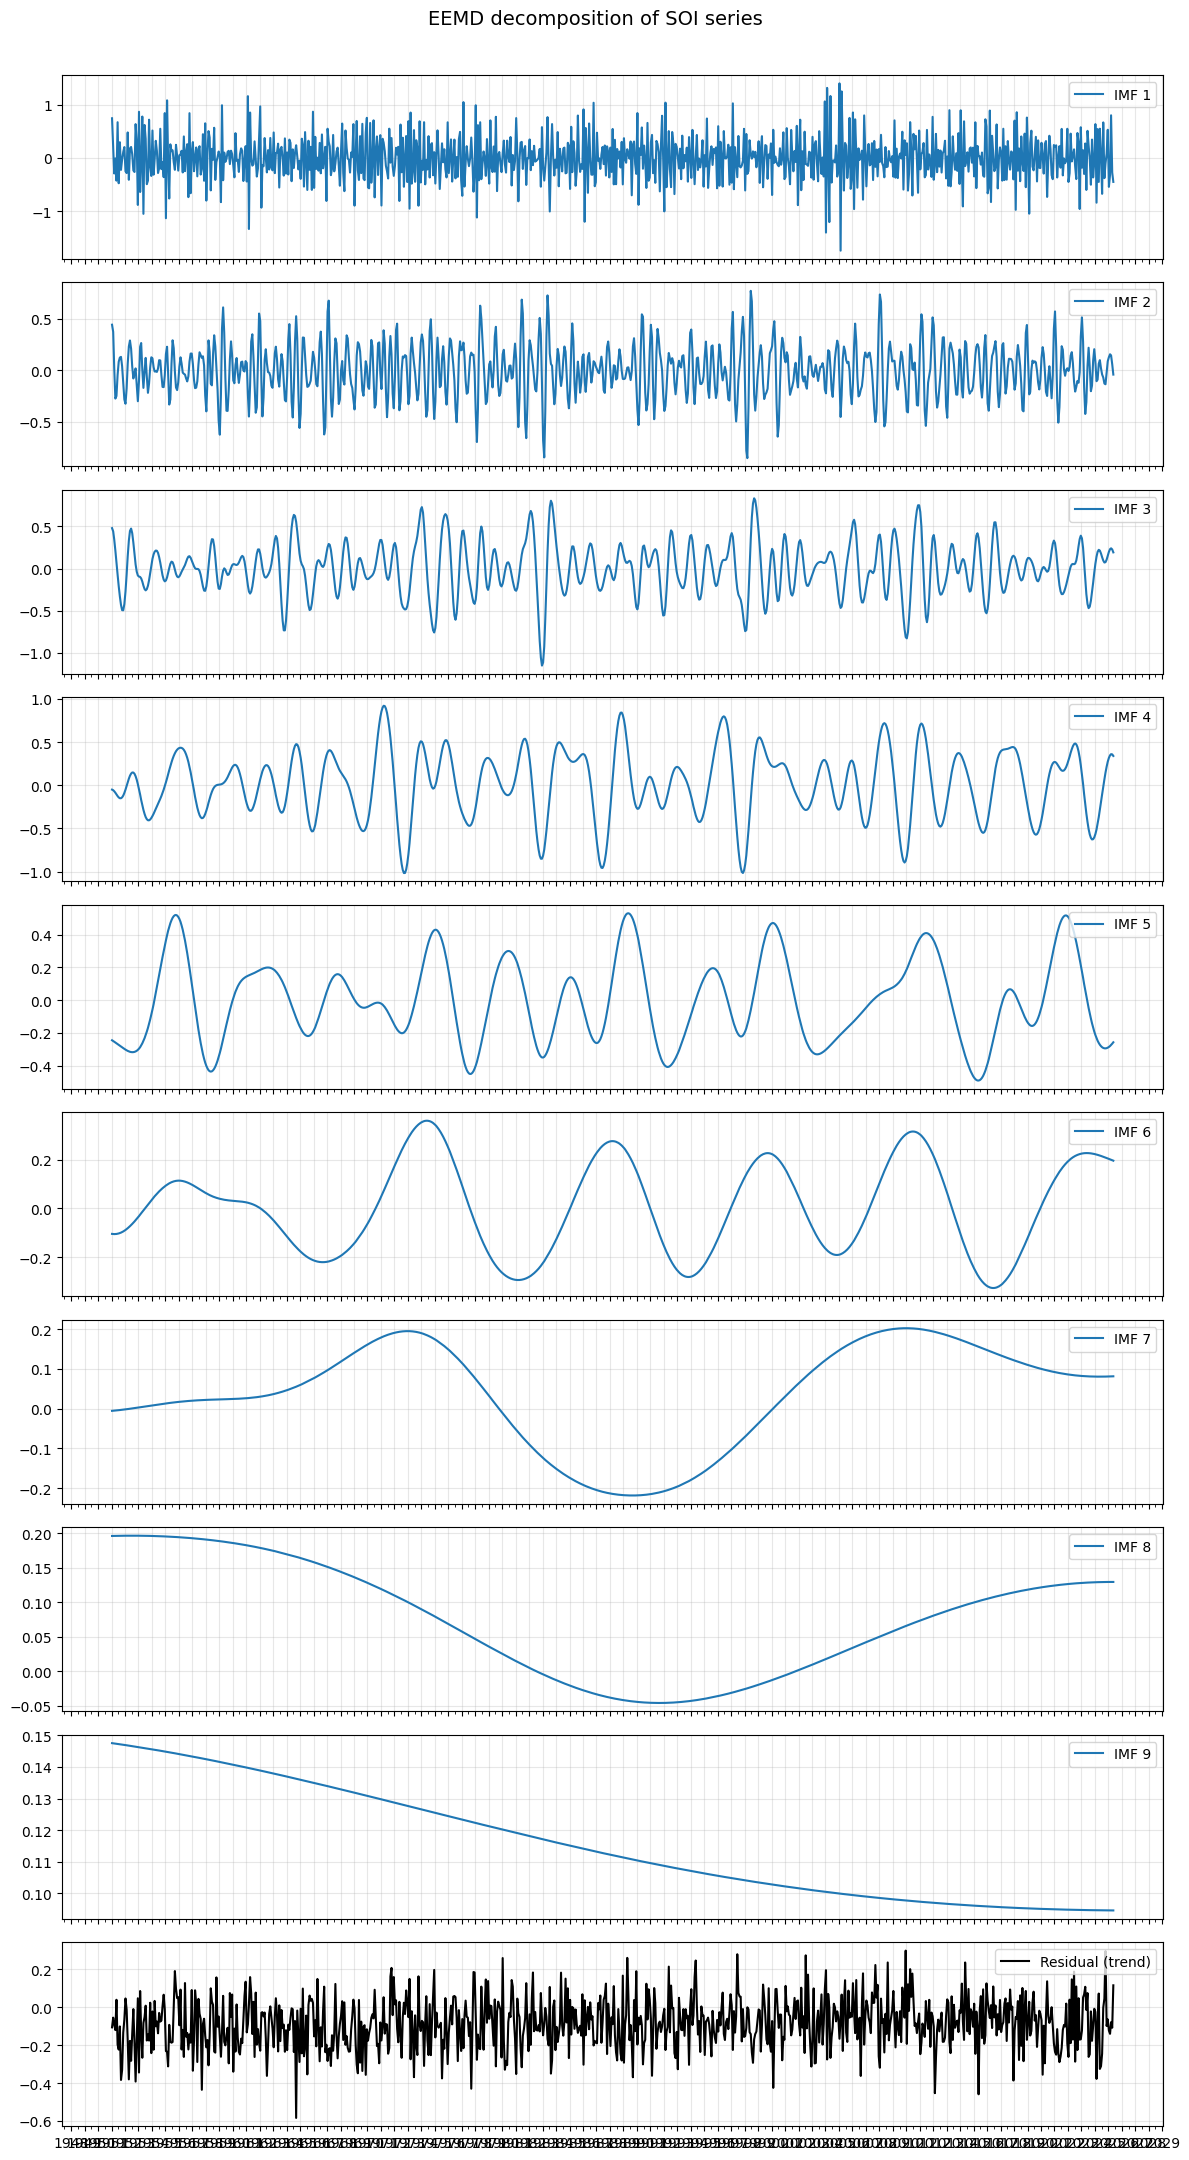

In [51]:
soi_series, IMF_soi, resid_soi = plot_eemd_decomposition_series(soi['SOI'], label="SOI")

In [57]:
def imf_fft_peak_periods(IMFs: np.ndarray,
                         dt: float = 1.0,
                         units: Literal["days", "months"] = "days") -> pd.DataFrame:
    """
    Compute dominant periods of IMFs using FFT.

    Args:
        IMFs: array of shape (n_imfs, n_samples)
        dt: sampling interval (1.0 = daily, 1/30 = monthly if unit is 'days')
        units: 'days' or 'months' — determines output unit

    Returns:
        DataFrame with:
            - IMF: 1-based index
            - peak_freq: cycles per unit (e.g., per day or month)
            - peak_period: inverse of peak frequency, in chosen unit
    """
    import numpy as np
    import pandas as pd

    n_imfs, N = IMFs.shape
    freqs = np.fft.rfftfreq(N, d=dt)
    result = []

    for i, imf in enumerate(IMFs, start=1):
        P = np.abs(np.fft.rfft(imf))**2
        idx = np.argmax(P[1:]) + 1  # skip DC
        f = freqs[idx]
        period = 1/f if f > 0 else np.inf
        result.append({
            "IMF": i,
            "peak_freq": f,
            f"peak_period_{units}": period
        })

    return pd.DataFrame(result)


In [58]:
fft_stats = imf_fft_peak_periods(IMF_soi, dt=1.0, units="months")
print(fft_stats)

   IMF  peak_freq  peak_period_months
0    1   0.404255            2.473684
1    2   0.111982            8.930000
2    3   0.054871           18.224490
3    4   0.022396           44.650000
4    5   0.007839          127.571429
5    6   0.006719          148.833333
6    7   0.002240          446.500000
7    8   0.001120          893.000000
8    9   0.001120          893.000000


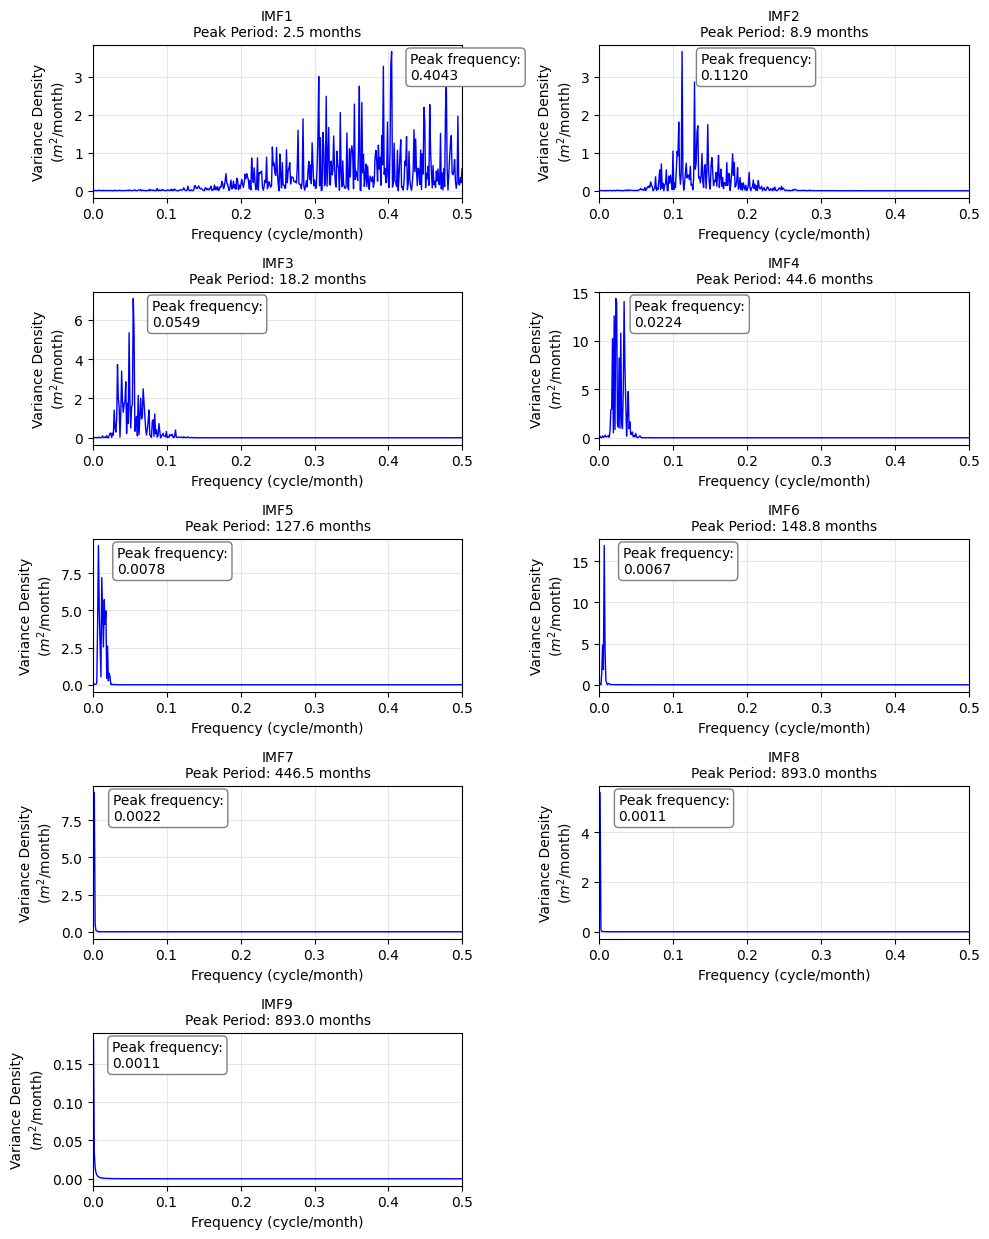

In [61]:
from scipy.signal import periodogram

# Simulated IMF data (for demo, replace with your real IMF matrix)
# np.random.seed(0)
# t = np.arange(0, 3650)  # 10 years of daily data
# IMFs = [np.sin(2 * np.pi * t / p) + 0.1 * np.random.randn(len(t)) for p in [90, 120, 180, 240, 365, 512, 730, 1000]]

# Plot IMF FFTs
n = len(IMF_soi)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows))
axes = axes.ravel()

for i, imf in enumerate(IMF_soi):
    f, Pxx = periodogram(imf, fs=1.0)  # fs=1 sample/day
    freq_monthly = f * 1  # cycles/month
    ax = axes[i]
    ax.plot(freq_monthly, Pxx, color='blue', lw=1)
    ax.set_xlim(0, 0.5)
    ax.set_xlabel("Frequency (cycle/month)")
    ax.set_ylabel("Variance Density\n($m^2$/month)")

    # Estimate peak period
    peak_idx = np.argmax(Pxx[1:]) + 1  # skip DC
    peak_freq = freq_monthly[peak_idx]
    peak_period = 1 / peak_freq if peak_freq > 0 else np.nan

    if peak_freq > 0 and peak_freq < 0.5:
        ax.text(peak_freq + 0.025, Pxx.max()*0.8,  # x and y placement
                f"Peak frequency:\n{peak_freq:.4f}",
                fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'),
                transform=ax.transData)
    ax.set_title(f"IMF{i+1}\nPeak Period: {peak_period:.1f} months", fontsize=10)
    ax.grid(True, alpha=0.3)

for i in range(len(IMF_soi), len(axes)):
    axes[i].axis("off")

plt.tight_layout()